In [ ]:
%pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import random

# Setting random seeds to replicate results easily
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
import json

In [ ]:
with open("data/product.json","r") as f:
    product_datas = json.load(f)
product_datas

# Collaborative Filtering

In [81]:
def build_ncf_model(n_users, n_items, embed_size, output_layer='dot'):
    '''
    params:
        n_users <int>: The number of user embedding vectors
        n_items <int>: The number of item embedding vectors
        embed_size <int>: The dimension of each embedding vector
        output_layer <str>: Indicates the instantiation of NCF to use, available options are either 'dot' or 'mlp'

    return:
        a keras Model object for the constructed ncf model 
    '''
    # Get the users and items input
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')


    # Get the embeddings of users and items
    user_emb = Embedding(output_dim=embed_size, input_dim=n_users, input_length=1)(user_input)
    user_emb = Reshape((embed_size,))(user_emb)
    item_emb = Embedding(output_dim=embed_size, input_dim=n_items, input_length=1)(item_input)
    item_emb = Reshape((embed_size,))(item_emb)


    if output_layer == 'dot':
        # Compute the dot product of users' and items' embeddings as the model output
        model_output = Dot(axes=1)([user_emb, item_emb])

    elif output_layer == 'mlp': # Try out different activatio function: 
                                # Softmax: Avoid using softmax activation for link prediction. It assigns probabilities for multi-class tasks and can lead to convergence issues and stagnant loss rates.
                                # ELU: consider negative inputs, a variation of ReLU
                                # sigmoid
        # Concatenate the users' and items' embeddings as the input of MLP
        mlp_input = Concatenate()([user_emb, item_emb])
        # Perform higher-level feature extraction with 128 units
        mlp_layer_1 = Dense(units=128, activation='Relu')(mlp_input)
        # The layer with 128 units learns more abstract representations
        # by capturing complex patterns and interactions in the data
        # Perform feature transformation with 64 units
        mlp_layer_2 = Dense(units=64, activation='Relu')(mlp_layer_1)
        
        # The layer with 64 units further refines the learned representations
        # and captures more intricate patterns in the data
        
        # Perform feature transformation with 32 units
        mlp_layer_3 = Dense(units=32, activation='Relu')(mlp_layer_2)
        
        # The layer with 32 units continues to extract higher-level features
        # and captures more fine-grained patterns in the data
        
        # Generate the final prediction with 1 unit
        model_output = Dense(units=1)(mlp_layer_3)
    else:
        raise NotImplementedError
    model = Model(inputs=[user_input, item_input], outputs=model_output)
    return model

In [96]:
re_df = pd.read_csv("data/review.csv")
val_df = pd.read_csv("data/validation.csv")

# Below try with removing more frequenct stuff

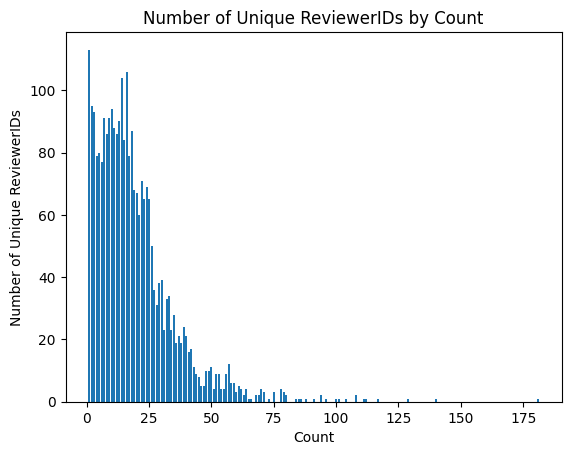

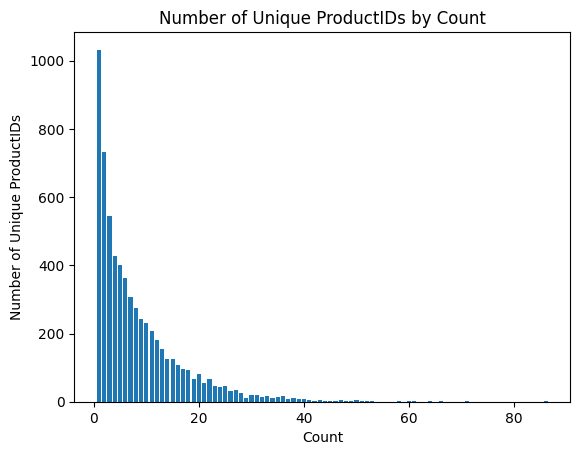

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict

reviewer_counts = Counter(re_df.ReviewerID)
product_counts = Counter(re_df.ProductID)

reviewer_count_freq = defaultdict(int)
for count in reviewer_counts.values():
    reviewer_count_freq[count] += 1

product_count_freq = defaultdict(int)
for count in product_counts.values():
    product_count_freq[count] += 1


# Create a bar graph for ReviewerID counts
plt.bar(reviewer_count_freq.keys(), reviewer_count_freq.values())
plt.xlabel('Count')
plt.ylabel('Number of Unique ReviewerIDs')
plt.title('Number of Unique ReviewerIDs by Count')
plt.show()

# Create a bar graph for ProductID counts
plt.bar(product_count_freq.keys(), product_count_freq.values())
plt.xlabel('Count')
plt.ylabel('Number of Unique ProductIDs')
plt.title('Number of Unique ProductIDs by Count')
plt.show()

In [97]:
# This filter out all Review ID that occur more than 50 times and product ID more then 20
import pandas as pd

existing_csv_path = 'data/review.csv'
new_csv_path = 'data/new_file.csv'

df = pd.read_csv(existing_csv_path)

# Filter Review IDs
reviewer_counts = df['ReviewerID'].value_counts()
valid_reviewer_ids = reviewer_counts[reviewer_counts >= 5].index
filtered_df = df[df['ReviewerID'].isin(valid_reviewer_ids)]

# Filter Product IDs
#product_counts = filtered_df['ProductID'].value_counts()
#valid_product_ids = product_counts[product_counts <= 20].index
#filtered_df = filtered_df[filtered_df['ProductID'].isin(valid_product_ids)]

# Save filtered data to a new CSV file
filtered_df.to_csv(new_csv_path, index=False)

In [98]:
re_df = pd.read_csv("data/new_file.csv")
val_df = pd.read_csv("data/validation.csv")

# The below is normal

In [99]:
reviewer_set = set(re_df.ReviewerID.unique())
product_set = set(re_df.ProductID.unique())

reviewer_vocab = dict(zip(reviewer_set, range(1, len(reviewer_set) + 1)))
reviewer_vocab['unk'] = 0 
n_users = len(reviewer_vocab)

product_vocab = dict(zip(product_set, range(1, len(product_set) + 1)))
product_vocab['unk'] = 0
n_items = len(product_vocab)

In [100]:
re_reviewer = re_df.ReviewerID.apply(lambda x: reviewer_vocab[x]).values
re_product = re_df.ProductID.apply(lambda x: product_vocab[x]).values
val_reviewer = val_df.ReviewerID.apply(lambda x: reviewer_vocab[x] if x in reviewer_vocab else 0).values # Ignore all types that are not in training set.
val_product = val_df.ProductID.apply(lambda x: product_vocab[x] if x in product_vocab else 0).values # Ignore all types that are not in training set.

In [101]:
re_ratings = re_df.Star.values
val_ratings = val_df.Star.values

In [102]:
from math import sqrt

import pandas as pd
from sklearn.metrics import (accuracy_score, mean_squared_error,
                             precision_recall_fscore_support)


# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

# For testing how the number of epochs and embedding affect the performance

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Define the values for epochs and embed_size
epochs = [5, 10, 15, 20, 25, 30]
embed_size = [100, 150, 200, 250, 300]

# Create an empty array to store the validation RMSE values
result = []
output_data = []

# Loop through the combinations of epochs and embed_size
for num_epochs in epochs:
    row = []
    for size in embed_size:
        # Build and compile the model with the desired parameters
        model = build_ncf_model(n_users, n_items, embed_size=size, output_layer='mlp')
        model.compile(optimizer='SGD', loss='mse')

        # Fit the model on the training data
        history = model.fit(
            [re_reviewer, re_product], 
            re_ratings, 
            epochs=num_epochs, 
            verbose=1,
            callbacks=[ModelCheckpoint('models/model.keras')])

        # Load the model and make predictions on the validation set
        model = tf.keras.models.load_model('models/model.keras')
        val_pred = model.predict([val_reviewer, val_product])

        # Calculate RMSE
        val_rmse = rmse(val_pred, val_ratings)
        row.append(val_rmse)
        output_data.append((num_epochs, size, val_rmse))
        print("Epochs: {}, Embed Size: {}, Val RMSE: {}".format(num_epochs, size, val_rmse))

    result.append(row)

# Convert the result list to a numpy array and reshape it
result = np.array(result).reshape(len(epochs), len(embed_size))
with open('output.txt', 'w') as f:
    for row in output_data:
        f.write('Epochs: {}, Embed Size: {}, Val RMSE: {}\n'.format(row[0], row[1], row[2]))

Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1347
Epoch 2/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7203
Epoch 3/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5613
Epoch 4/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5211
Epoch 5/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4967
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epochs: 5, Embed Size: 100, Val RMSE: 0.8491150505213618
Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0726
Epoch 2/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6812
Epoch 3/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5491
Epoch 4/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5120
Epoch 5/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4889
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epochs: 5, Embed Size: 150, Val RMSE: 0.8902744682053283
Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1086
Epoch 2/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6532
Epoch 3/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5462
Epoch 4/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5132
Epoch 5/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4912
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epochs: 5, Embed Size: 200, Val RMSE: 0.8529556981875837
Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1182
Epoch 2/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6420
Epoch 3/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5381
Epoch 4/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5060
Epoch 5/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4847
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epochs: 5, Embed Size: 250, Val RMSE: 0.8497965071898265
Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0738
Epoch 2/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6408
Epoch 3/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5400
Epoch 4/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5066
Epoch 5/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4850
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epochs: 5, Embed Size: 300, Val RMSE: 0.8452937858466143
Epoch 1/10


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0655
Epoch 2/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6664
Epoch 3/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5532
Epoch 4/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5200
Epoch 5/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4969
Epoch 6/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4787
Epoch 7/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4647
Epoch 8/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4539
Epoch 9/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4455
Epoch 10/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4386
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epochs: 10, Embed Size: 100, Val RMSE: 0.8514441185597986
Epoch 1/10


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0697
Epoch 2/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6427
Epoch 3/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5436
Epoch 4/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5113
Epoch 5/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4894
Epoch 6/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4734
Epoch 7/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4615
Epoch 8/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4523
Epoch 9/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4450
Epoch 10/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4390
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epochs: 10, Embed Size: 150, Val RMSE: 0.8504568389088585


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1115
Epoch 2/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6524
Epoch 3/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5443
Epoch 4/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5109
Epoch 5/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4887
Epoch 6/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4723
Epoch 7/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4600
Epoch 8/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4506
Epoch 9/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4430
Epoch 10/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4368
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epochs: 10, Embed Size: 200, Val RMSE: 0.8719781601922261
Epoch 1/10


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0962
Epoch 2/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6365
Epoch 3/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5377
Epoch 4/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5055
Epoch 5/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4847
Epoch 6/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4697
Epoch 7/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4586
Epoch 8/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4501
Epoch 9/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4433
Epoch 10/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4377
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epochs: 10, Embed Size: 250, Val RMSE: 0.8690025779309846
Epoch 1/10


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0895
Epoch 2/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6474
Epoch 3/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5405
Epoch 4/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5070
Epoch 5/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4858
Epoch 6/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4707
Epoch 7/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4595
Epoch 8/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4509
Epoch 9/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4440
Epoch 10/10
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4383
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epochs: 10, Embed Size: 300, Val RMSE: 0.8546120476122073
Epoch 1/15


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0941
Epoch 2/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6625
Epoch 3/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5487
Epoch 4/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5161
Epoch 5/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4938
Epoch 6/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4768
Epoch 7/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4640
Epoch 8/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4542
Epoch 9/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4465
Epoch 10/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4403
Epoch 11/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4350
Epoch 12/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4304
Epoch 13/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4262
Epoch 14/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4223
Epoch 15/15
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1186
Epoch 2/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6490
Epoch 3/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5444
Epoch 4/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5124
Epoch 5/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4904
Epoch 6/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4740
Epoch 7/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4617
Epoch 8/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4524
Epoch 9/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4450
Epoch 10/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4390
Epoch 11/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4338
Epoch 12/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4292
Epoch 13/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4251
Epoch 14/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4212
Epoch 15/15
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1176
Epoch 2/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6457
Epoch 3/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5403
Epoch 4/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5079
Epoch 5/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4864
Epoch 6/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4709
Epoch 7/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4593
Epoch 8/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4505
Epoch 9/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4434
Epoch 10/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4375
Epoch 11/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4324
Epoch 12/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4278
Epoch 13/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4237
Epoch 14/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4199
Epoch 15/15
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1210
Epoch 2/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6652
Epoch 3/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5445
Epoch 4/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5093
Epoch 5/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4872
Epoch 6/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4714
Epoch 7/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4597
Epoch 8/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4507
Epoch 9/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4436
Epoch 10/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4377
Epoch 11/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4327
Epoch 12/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4282
Epoch 13/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4240
Epoch 14/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4201
Epoch 15/15
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0965
Epoch 2/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6412
Epoch 3/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5396
Epoch 4/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5074
Epoch 5/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4865
Epoch 6/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4713
Epoch 7/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4600
Epoch 8/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4515
Epoch 9/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4448
Epoch 10/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4393
Epoch 11/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4347
Epoch 12/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4307
Epoch 13/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4270
Epoch 14/15
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4236
Epoch 15/15
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0609
Epoch 2/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6637
Epoch 3/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5474
Epoch 4/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5131
Epoch 5/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4907
Epoch 6/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4742
Epoch 7/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4619
Epoch 8/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4525
Epoch 9/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4450
Epoch 10/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4388
Epoch 11/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4335
Epoch 12/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4288
Epoch 13/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4245
Epoch 14/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4206
Epoch 15/20
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0927
Epoch 2/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6449
Epoch 3/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5429
Epoch 4/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5103
Epoch 5/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4885
Epoch 6/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4723
Epoch 7/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4602
Epoch 8/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4509
Epoch 9/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4434
Epoch 10/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4373
Epoch 11/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4321
Epoch 12/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4275
Epoch 13/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4234
Epoch 14/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4196
Epoch 15/20
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0644
Epoch 2/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6304
Epoch 3/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5399
Epoch 4/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5099
Epoch 5/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4890
Epoch 6/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4734
Epoch 7/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4617
Epoch 8/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4526
Epoch 9/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4455
Epoch 10/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4397
Epoch 11/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4347
Epoch 12/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4303
Epoch 13/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4263
Epoch 14/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4226
Epoch 15/20
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1654
Epoch 2/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6735
Epoch 3/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5461
Epoch 4/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5106
Epoch 5/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4883
Epoch 6/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4721
Epoch 7/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4600
Epoch 8/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4507
Epoch 9/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4433
Epoch 10/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4372
Epoch 11/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4319
Epoch 12/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4274
Epoch 13/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4233
Epoch 14/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4195
Epoch 15/20
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1096
Epoch 2/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6379
Epoch 3/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5388
Epoch 4/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5073
Epoch 5/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4866
Epoch 6/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4717
Epoch 7/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4605
Epoch 8/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4520
Epoch 9/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4452
Epoch 10/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4397
Epoch 11/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4350
Epoch 12/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4309
Epoch 13/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4272
Epoch 14/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4238
Epoch 15/20
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1562
Epoch 2/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6505
Epoch 3/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5482
Epoch 4/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5175
Epoch 5/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4956
Epoch 6/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4785
Epoch 7/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4657
Epoch 8/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4560
Epoch 9/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4485
Epoch 10/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4425
Epoch 11/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4376
Epoch 12/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4334
Epoch 13/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4297
Epoch 14/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4264
Epoch 15/25
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0741
Epoch 2/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6417
Epoch 3/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5395
Epoch 4/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5075
Epoch 5/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4866
Epoch 6/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4713
Epoch 7/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4600
Epoch 8/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4514
Epoch 9/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4446
Epoch 10/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4390
Epoch 11/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4342
Epoch 12/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4300
Epoch 13/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4262
Epoch 14/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4226
Epoch 15/25
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0869
Epoch 2/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6380
Epoch 3/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5459
Epoch 4/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5147
Epoch 5/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4933
Epoch 6/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4771
Epoch 7/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4648
Epoch 8/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4553
Epoch 9/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4478
Epoch 10/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4416
Epoch 11/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4363
Epoch 12/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4317
Epoch 13/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4275
Epoch 14/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4236
Epoch 15/25
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0867
Epoch 2/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6329
Epoch 3/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5356
Epoch 4/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5037
Epoch 5/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4832
Epoch 6/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4686
Epoch 7/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4580
Epoch 8/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4498
Epoch 9/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4434
Epoch 10/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4380
Epoch 11/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4334
Epoch 12/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4294
Epoch 13/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4257
Epoch 14/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4223
Epoch 15/25
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0807
Epoch 2/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6212
Epoch 3/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5342
Epoch 4/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5038
Epoch 5/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4837
Epoch 6/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4694
Epoch 7/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4588
Epoch 8/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4506
Epoch 9/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4442
Epoch 10/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4389
Epoch 11/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4344
Epoch 12/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4304
Epoch 13/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4268
Epoch 14/25
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4235
Epoch 15/25
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0965
Epoch 2/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6578
Epoch 3/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5517
Epoch 4/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5199
Epoch 5/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4973
Epoch 6/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4795
Epoch 7/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4659
Epoch 8/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4555
Epoch 9/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4473
Epoch 10/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4406
Epoch 11/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4351
Epoch 12/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4302
Epoch 13/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4259
Epoch 14/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4219
Epoch 15/30
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1092
Epoch 2/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6386
Epoch 3/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5433
Epoch 4/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5114
Epoch 5/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4899
Epoch 6/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4741
Epoch 7/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4623
Epoch 8/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4534
Epoch 9/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4463
Epoch 10/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4405
Epoch 11/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4355
Epoch 12/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4312
Epoch 13/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4272
Epoch 14/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4235
Epoch 15/30
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1511
Epoch 2/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6649
Epoch 3/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5466
Epoch 4/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5126
Epoch 5/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4909
Epoch 6/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4751
Epoch 7/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4634
Epoch 8/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4545
Epoch 9/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4474
Epoch 10/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4417
Epoch 11/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4369
Epoch 12/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4327
Epoch 13/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4290
Epoch 14/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4255
Epoch 15/30
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0812
Epoch 2/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6439
Epoch 3/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5411
Epoch 4/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5083
Epoch 5/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4872
Epoch 6/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4718
Epoch 7/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4604
Epoch 8/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4515
Epoch 9/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4445
Epoch 10/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4386
Epoch 11/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4336
Epoch 12/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4291
Epoch 13/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4250
Epoch 14/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4212
Epoch 15/30
1619/1619 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0662
Epoch 2/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6292
Epoch 3/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5383
Epoch 4/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5067
Epoch 5/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4856
Epoch 6/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4703
Epoch 7/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4589
Epoch 8/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4502
Epoch 9/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4432
Epoch 10/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4374
Epoch 11/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4323
Epoch 12/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4278
Epoch 13/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4237
Epoch 14/30
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4198
Epoch 15/30
1619/1619 ━━━━━━━━━━━━━━━━━━

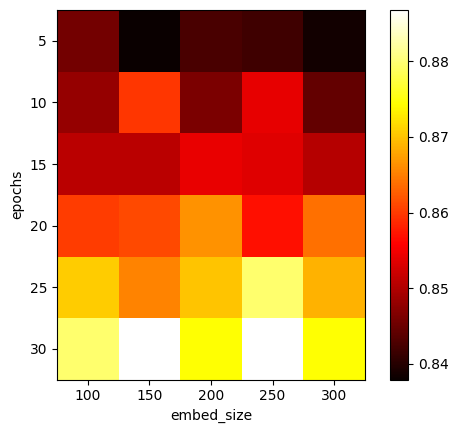

In [89]:
# Plot the heatmap
plt.imshow(result, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=embed_size)
plt.xlabel("embed_size")
plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=epochs)
plt.ylabel("epochs")
plt.show()

# Best 

In [92]:
model = build_ncf_model(n_users, n_items, embed_size=150, output_layer='mlp') #SGD
model.compile(optimizer='SGD', loss='mse') #SGD: 1. SGD has been observed to converge to sharp minima more effectively than Adam 2. SGD can be more robust to noisy gradients compared to Adam. In some cases, Adam's adaptive learning rate and momentum can overly amplify the effect of noisy gradients, leading to erratic updates.

history = model.fit(
        [re_reviewer, re_product], 
        re_ratings, 
        epochs=5, 
        verbose=1,
        callbacks=[ModelCheckpoint('models/model.keras')])

Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1104
Epoch 2/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6565
Epoch 3/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5445
Epoch 4/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5090
Epoch 5/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4864


In [95]:
model = tf.keras.models.load_model('models/model.keras')
val_pred = model.predict([val_reviewer, val_product])
print("Validation set RMSE: ", rmse(val_pred, val_ratings))

#Target: 0.86

df_predictions = pd.DataFrame({
    'ReviewerID': val_df['ReviewerID'],
    'ProductID': val_df['ProductID'],
    'Star': val_pred.flatten()
})
df_predictions.to_csv('validation_prediction.csv', index=False)

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation set RMSE:  0.8394263842021891


In [94]:
test_df = pd.read_csv("data/prediction.csv")

# Ignore all types that are not in training set.
test_reviewer = test_df.ReviewerID.apply(lambda x: reviewer_vocab[x] if x in reviewer_vocab else 0).values
test_product = test_df.ProductID.apply(lambda x: product_vocab[x] if x in product_vocab else 0).values

test_pred = model.predict([test_reviewer, test_product])

#### Unkown compare to what ?
df_predictions = pd.DataFrame({
    'ReviewerID': val_df['ReviewerID'],
    'ProductID': val_df['ProductID'],
    'Star': val_pred.flatten()
})
df_predictions.to_csv('data/prediction.csv', index=False)

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
